# About
Question Similarity using machine learning and deep learning. 


In [29]:
#installing xgboost
#!pip install xgboost
#importing modules
import os
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import pickle
import json
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import numpy as np
import tqdm
from scipy.stats import kurtosis
from scipy.stats import skew
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/QuoraQuestionPairsDataset')

In [3]:
!ls

fuzzy_features1.csv		       sample_submission.csv.zip  train.csv
GoogleNews-vectors-negative300.bin.gz  test.csv			  train.csv.zip
quora-question-pairs.zip	       test.csv.zip


In [4]:
#!unzip quora-question-pairs.zip
#!unzip train.csv.zip

In [5]:
train_dataset = pd.read_csv('train.csv')

In [6]:
train_dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# 1. Exploratory Data Analysis and Feature Engineering.

In [7]:
#dropping unneccessary columns
train_dataset = train_dataset.drop(['id','qid1','qid2'],axis=1)

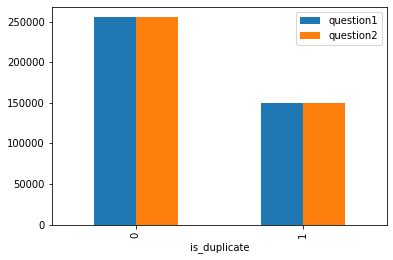

In [8]:
#checking number of class labels
train_dataset.groupby('is_duplicate').count().plot.bar()

In [9]:
#total number of question paris for training
print("Total number of Q&A pairs is {}".format(len(train_dataset)))

Total number of Q&A pairs is 404290


In [10]:
#checking if any row has null values
null_rows  = train_dataset[train_dataset.isnull().any(1)]
print(null_rows)

                               question1  ... is_duplicate
105780    How can I develop android app?  ...            0
201841  How can I create an Android app?  ...            0
363362                               NaN  ...            0

[3 rows x 3 columns]


In [11]:
#filling empty rows with ""
train_dataset = train_dataset.fillna("")
#calculating the null rows again
null_rows = train_dataset[train_dataset.isnull().any(1)]
print(null_rows)

Empty DataFrame
Columns: [question1, question2, is_duplicate]
Index: []


In [12]:
train_dataset.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [13]:
#finding number of words in question 1 and question 2
train_dataset['q1_length'] = train_dataset.question1.apply(lambda x: len(str(x)))
train_dataset['q2_length'] = train_dataset.question2.apply(lambda x: len(str(x)))

In [14]:
train_dataset.head()

,question1,question2,is_duplicate,q1_length,q2_length
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39


In [15]:
#finding absolute difference in length of questions
train_dataset['question_len_diff'] = abs(train_dataset.q2_length - train_dataset.q1_length) 

In [16]:
train_dataset.head()

,question1,question2,is_duplicate,q1_length,q2_length,question_len_diff
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37


In [17]:
#finding length of common words between questions
train_dataset['len_common_words'] = train_dataset.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [18]:
train_dataset.head()

,question1,question2,is_duplicate,q1_length,q2_length,question_len_diff,len_common_words
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,10
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,4
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,4
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,2


# Next Step
Let's fit our Machine learning model on these basic features and evaluate the performance.


In [ ]:
naive_features = train_dataset.drop(['question1','question2'], axis=1)

In [ ]:
naive_features.head(10)

,is_duplicate,q1_length,q2_length,question_len_diff,len_common_words
0,0,66,57,9,10
1,0,51,88,37,4
2,0,73,59,14,4
3,0,50,65,15,0
4,0,76,39,37,2
5,1,86,90,4,8
6,0,19,62,43,0
7,1,30,41,11,4
8,0,31,37,6,6
9,0,60,49,11,3


In [ ]:
label = naive_features.iloc[:,0]
naive_features = naive_features.iloc[:,1:5]

In [ ]:
label.head(10)

0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: is_duplicate, dtype: int64

In [ ]:
naive_features.head(10)

,q1_length,q2_length,question_len_diff,len_common_words
0,66,57,9,10
1,51,88,37,4
2,73,59,14,4
3,50,65,15,0
4,76,39,37,2
5,86,90,4,8
6,19,62,43,0
7,30,41,11,4
8,31,37,6,6
9,60,49,11,3


In [ ]:
X_train_naive,X_test_naive, y_train_naive,y_test_naive = train_test_split(naive_features, label, random_state=42, test_size=0.25)

In [ ]:
XGBClassifier().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [ ]:
#bayesian optimization
parameters = {'nthread': hp.choice('nthread', [4,8]), #when use hyperthread, xgboost may become slower
              'objective':hp.choice('objective',['binary:logistic']), #for n_classes greater than 2, you can use multi:softmax or multi:softprob
              'learning_rate': hp.choice('learning_rate', [0.01]), #so called `eta` value
              'max_depth': hp.choice('max_depth',[2,3,4,5,6,7,8,9]),
              'min_child_weight': hp.choice('min_child_weight',[2,3,4,5,6,7,8,9,10]),
              'silent': hp.choice('silent', [1]),
              'subsample': hp.choice('subsample',[0.8]),
              'colsample_bytree': hp.choice('colsample_bytree',[0.7]),
              'n_estimators': hp.choice('n_estimators', [1,10,100,1000,10000]), #number of trees, change it to 1000 for better results
              'missing':hp.choice('missing',[-1456,-999]),
              'seed': hp.choice('seed',[42,888,1337])}

def objective(parameters):
    model = XGBClassifier(nthread = parameters['nthread'], 
                                  objective = parameters['objective'],
                                 learning_rate = parameters['learning_rate'],
                                 max_depth = parameters['max_depth'],
                                 min_child_weight = parameters['min_child_weight'],
                                 silent = parameters['silent'],
                                 subsample = parameters['subsample'],
                                 colsample_bytree = parameters['colsample_bytree'],
                                 n_estimators = parameters['n_estimators'], 
                                 missing = parameters['missing'],
                                 seed = parameters['seed']
                                 )
    
    accuracy = cross_val_score(model, X_train_naive, y_train_naive, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn= objective,
            space= parameters,
            algo= tpe.suggest,
            max_evals = 10,
            trials= trials)
best
#naive_clf = GridSearchCV(XGBClassifier(), parameters, n_jobs=12, 
#                   cv=StratifiedKFold(shuffle=True), 
#                   scoring='roc_auc',
#                   verbose=2, refit=True).fit(X_train_naive, y_train_naive).best_estimator_

100%|██████████| 10/10 [28:08<00:00, 168.80s/it, best loss: -0.7005708853201065]


{'colsample_bytree': 0,
 'learning_rate': 0,
 'max_depth': 0,
 'min_child_weight': 0,
 'missing': 1,
 'n_estimators': 4,
 'nthread': 1,
 'objective': 0,
 'seed': 1,
 'silent': 0,
 'subsample': 0}

Run hyperopt for more max_evals,Right now we will use from our last session

In [ ]:
#
trained_classifier =  XGBClassifier(nthread = 4, 
                                  objective = 'binary:logistic',
                                 learning_rate =0.01,
                                 max_depth = 4,
                                 min_child_weight = 11,
                                 silent = 0,
                                 subsample = 0.8,
                                 colsample_bytree = 0.7,
                                 n_estimators = 1000,
                                 seed = 42).fit(X_train_naive, y_train_naive)


In [ ]:
predictionforest = trained_classifier.predict(X_test_naive)
print(confusion_matrix(y_test_naive,predictionforest))
print(classification_report(y_test_naive,predictionforest))
accuracy = accuracy_score(y_test_naive,predictionforest)
print(accuracy)

[[46776 16783]
 [13900 23614]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.75     63559
           1       0.58      0.63      0.61     37514

    accuracy                           0.70    101073
   macro avg       0.68      0.68      0.68    101073
weighted avg       0.70      0.70      0.70    101073

0.6964273346986831


# Observation
The accuracy is not good.
Let's increase it via incorporating more features, primarily fuzzy features. [Reference 1](https://www.google.com/search?q=fuzzy+feature+extraction+in+text+python&client=firefox-b-d&ei=q7JhYOOEH9re9QPQ9afgDA&oq=fuzzy+feature+extraction+in+texts%3A&gs_lcp=Cgdnd3Mtd2l6EAMYADIHCCEQChCgATIHCCEQChCgAVD3cFiefWC3hQFoA3AAeACAAZECiAHpBZIBBTAuMy4xmAEAoAEBqgEHZ3dzLXdpesABAQ&sclient=gws-wiz) [Reference 2](https://github.com/abhishekkrthakur/is_that_a_duplicate_quora_question/blob/master/feature_engineering.py) 

In [19]:
#Basic fuzzy features
train_dataset['fuzz_qratio'] = train_dataset.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")
train_dataset['fuzz_WRatio'] = train_dataset.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")
train_dataset['fuzz_partial_ratio'] = train_dataset.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")
train_dataset['fuzz_partial_token_set_ratio'] = train_dataset.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")
train_dataset['fuzz_partial_token_sort_ratio'] = train_dataset.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")
train_dataset['fuzz_token_set_ratio'] = train_dataset.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")
train_dataset['fuzz_token_sort_ratio'] = train_dataset.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("Processed")

Processed
Processed
Processed
Processed
Processed
Processed
Processed


In [18]:
#helper function for more complex 
def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [22]:
train_dataset.head(10)

,question1,question2,is_duplicate,q1_length,q2_length,question_len_diff,len_common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,10,93,95,98,100,88,100,93
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,4,66,86,73,100,73,86,63
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,4,43,60,41,100,71,63,63
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,0,9,27,20,32,30,28,24
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,2,35,86,54,100,67,67,47
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90,4,8,72,74,67,100,71,78,74
6,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62,43,0,20,35,32,39,39,24,23
7,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41,11,4,61,67,67,100,69,71,61
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,6,6,86,88,90,100,93,93,87
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49,11,3,49,62,57,100,55,65,44


In [23]:
#saving the dataframe till now as a checkpoint
train_dataset.to_csv('fuzzy_features1.csv', index=False)

In [4]:
#loading csv from last checkpoint
train_dataset = pd.read_csv('fuzzy_features1.csv')

In [5]:
train_dataset.head()

,question1,question2,is_duplicate,q1_length,q2_length,question_len_diff,len_common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,10,93,95,98,100,88,100,93
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,4,66,86,73,100,73,86,63
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,4,43,60,41,100,71,63,63
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,0,9,27,20,32,30,28,24
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,2,35,86,54,100,67,67,47


In [6]:
#optional
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"


In [ ]:
#feature extraction reference :: https://github.com/abhishekkrthakur/is_that_a_duplicate_quora_question/blob/master/feature_engineering.py
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
print("Starting up")
train_dataset['wmd'] = train_dataset.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)
print("Processed")

norm_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
train_dataset['norm_wmd'] = train_dataset.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)
print("Processed")




In [ ]:
question1_vectors = np.zeros((train_dataset.shape[0], 300))
error_count = 0
for i, q in tqdm.tqdm(enumerate(train_dataset.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((train_dataset.shape[0], 300))
for i, q in tqdm.tqdm(enumerate(train_dataset.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

train_dataset['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                        np.nan_to_num(question2_vectors))]

print("Processed")  
train_dataset['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]
print("Processed")
train_dataset['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]
print("Processed")
train_dataset['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]

print("Processed")
train_dataset['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]
print("Processed")
train_dataset['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]
print("Processed")
train_dataset['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]
print("Processed")


In [24]:
train_dataset['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
print("Processed")
train_dataset['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
print("Processed")
train_dataset['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
print("Processed")
train_dataset['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]
print("Processed")

Processed
Processed
Processed
Processed


In [30]:
pickle.dump(question1_vectors, open('q1_w2v.pkl', 'wb'), -1)
pickle.dump(question2_vectors, open('q2_w2v.pkl', 'wb'), -1)

train_dataset.to_csv('final_features.csv', index=False)

In [31]:
train_dataset.head(10)

,question1,question2,is_duplicate,q1_length,q2_length,question_len_diff,len_common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,10,93,95,98,100,88,100,93,0.564615,0.217555,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,4,66,86,73,100,73,86,63,3.772346,1.368796,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,4,43,60,41,100,71,63,63,1.780585,0.639209,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,0,9,27,20,32,30,28,24,3.741994,1.263719,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,2,35,86,54,100,67,67,47,3.659165,1.240908,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90,4,8,72,74,67,100,71,78,74,2.357449,0.780579,0.275242,10.254048,1.0,150.335589,0.741946,0.337470,0.400061,0.102946,-0.077741,-0.335505,-0.057847
6,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62,43,0,20,35,32,39,39,24,23,3.546062,1.359521,0.820637,17.414754,1.0,200.598725,1.281122,0.597082,0.816676,-0.090366,-0.000266,0.296892,0.130717
7,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41,11,4,61,67,67,100,69,71,61,1.691323,0.736001,0.064615,5.008762,1.0,95.395891,0.359486,0.161125,0.187150,0.346824,0.368469,0.635773,0.865446
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,6,6,86,88,90,100,93,93,87,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.202336,0.202336,-0.434927,-0.434927
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49,11,3,49,62,57,100,55,65,44,1.258243,0.459266,0.284710,10.634987,1.0,153.647611,0.754599,0.337939,0.409126,0.120050,0.204449,-0.214573,-0.126814


In [33]:
fuzzy_features = train_dataset.drop(['question1','question2'], axis=1)

In [34]:
fuzzy_features.head()

,is_duplicate,q1_length,q2_length,question_len_diff,len_common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0,66,57,9,10,93,95,98,100,88,100,93,0.564615,0.217555,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301
1,0,51,88,37,4,66,86,73,100,73,86,63,3.772346,1.368796,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444
2,0,73,59,14,4,43,60,41,100,71,63,63,1.780585,0.639209,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131
3,0,50,65,15,0,9,27,20,32,30,28,24,3.741994,1.263719,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568
4,0,76,39,37,2,35,86,54,100,67,67,47,3.659165,1.240908,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876


In [35]:
fuzzy_label = fuzzy_features.iloc[:,0]
fuzzy_features = fuzzy_features.iloc[:,1:24]

In [36]:
fuzzy_features.head()

,q1_length,q2_length,question_len_diff,len_common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec
0,66,57,9,10,93,95,98,100,88,100,93,0.564615,0.217555,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416
1,51,88,37,4,66,86,73,100,73,86,63,3.772346,1.368796,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010
2,73,59,14,4,43,60,41,100,71,63,63,1.780585,0.639209,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306,0.239752,0.144554,0.026759
3,50,65,15,0,9,27,20,32,30,28,24,3.741994,1.263719,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421,-0.002527,0.069649,-0.244560
4,76,39,37,2,35,86,54,100,67,67,47,3.659165,1.240908,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900


In [37]:
X_train_fuzzy,X_test_fuzzy, y_train_fuzzy,y_test_fuzzy = train_test_split(fuzzy_features, fuzzy_label, random_state=42, test_size=0.25)

In [40]:
#let's do hyperparam tuning using spark
!pip install --upgrade sk-dist
from skdist.distribute.search import DistGridSearchCV

     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for sk-dist: filename=sk_dist-0.1.9-cp37-none-any.whl size=51838 sha256=4731848646006107dff5f70c9d239e94bc140f83ad72384ec8e9b8e3b6feb2b0
  Stored in directory: /root/.cache/pip/wheels/60/fa/b7/e4c8f3f076a7c907655ea401351658200528b2e73981afb6ea
Successfully built sk-dist


In [52]:
xgb_classifier = XGBClassifier()

fuzzy_param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 20],
        'learning_rate': [0.001, 0.01, 0.1],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.4,  0.7, 1.0],
        'colsample_bylevel': [0.4, 0.7, 0.9],
        'min_child_weight': [0.5, 3.0, 5.0,  10.0],
        'gamma': [0, 0.5, 1.0],
        'reg_lambda': [0.1, 5.0,  50.0, 100.0],
        'n_estimators': [10,100,1000]}


randomsearch_classifier = RandomizedSearchCV(xgb_classifier, fuzzy_param_grid, n_iter=20,
                            n_jobs=24, verbose=1, cv=2,
                            scoring='roc_auc', refit=True, random_state=42)
randomsearch_classifier.fit(X_train_fuzzy, y_train_fuzzy)

best_score = randomsearch_classifier.best_score_
best_params = randomsearch_classifier.best_params_
print("Best score: {}".format(best_score))
# print("Best params: ")
# for param_name in sorted(best_params.keys()):
#     print('%s: %r' % (param_name, best_params[param_name]))

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed: 49.4min remaining:  8.7min
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed: 53.3min finished


Best score: 0.853159565387798


In [53]:
prediction_fuzzy = randomsearch_classifier.predict(X_test_fuzzy)
print(confusion_matrix(y_test_fuzzy,prediction_fuzzy))
print(classification_report(y_test_fuzzy,prediction_fuzzy))
accuracy = accuracy_score(y_test_fuzzy,prediction_fuzzy)
print(accuracy)

[[51177 12382]
 [10116 27398]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     63559
           1       0.69      0.73      0.71     37514

    accuracy                           0.78    101073
   macro avg       0.76      0.77      0.76    101073
weighted avg       0.78      0.78      0.78    101073

0.7774084077844726


In [54]:
#saving the model for serving
with open('xgboost_question_similarity_model.pkl','wb') as f:
    pickle.dump(randomsearch_classifier,f)